In [6]:
import os
import numpy as np
import librosa
import librosa.effects
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import kagglehub
import joblib
import matplotlib.pyplot as plt

# Check Apple M1 GPU (Metal) availability
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("✅ GPU Enabled for Apple Silicon (via Metal)")
    except RuntimeError as e:
        print(e)
else:
    print("❌ No GPU detected. Using CPU.")

# Enable Mixed Precision Training (FP16) if supported
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("🔧 Mixed Precision set to FP16")
except:
    print("⚠️ mixed_float16 not supported. Falling back to float32.")
    policy = mixed_precision.Policy('float32')
    mixed_precision.set_global_policy(policy)

/opt/anaconda3/envs/style-transfer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


❌ No GPU detected. Using CPU.
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
🔧 Mixed Precision set to FP16


In [7]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("aryashah2k/noise-reduced-uaspeech-dysarthria-dataset")
dataset_root = path  # Use direct path, avoiding extra "versions/1/"

# Define folders for Dysarthric & Control data
uaspeech_path = os.path.join(dataset_root, "noisereduced-uaspeech")          # Dysarthric speech
control_path = os.path.join(dataset_root, "noisereduced-uaspeech-control")  # Control group

print("Dysarthric Speech Path:", uaspeech_path)
print("Control Speech Path:", control_path)

100%|██████████████████████████████████████| 8.01G/8.01G [12:01<00:00, 11.9MB/s]

Extracting model files...


Dysarthric Speech Path: /Users/manankumarsingh/.cache/kagglehub/datasets/aryashah2k/noise-reduced-uaspeech-dysarthria-dataset/versions/1/noisereduced-uaspeech
Control Speech Path: /Users/manankumarsingh/.cache/kagglehub/datasets/aryashah2k/noise-reduced-uaspeech-dysarthria-dataset/versions/1/noisereduced-uaspeech-control


In [8]:
# Audio & Feature Extraction Parameters
SAMPLE_RATE = 44100
N_MFCC = 13

# Category Mapping
severity_mapping = {
    'Dysarthric': 1,
    'Control': 0
}


In [42]:
def extract_features(file_path):
    """
    Extract MFCC and Mel Spectrogram features from an audio file,
    applying gentler augmentation (time-stretch, pitch shift, noise).
    """
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Random Time Stretching (30% chance, smaller range)
    if np.random.rand() < 0.3:
        rate = np.random.uniform(0.9, 1.1)
        y = librosa.effects.time_stretch(y, rate=rate)

    # Random Pitch Shift (30% chance, ±1 semitone)
    if np.random.rand() < 0.3:
        semitones = np.random.uniform(-1, 1)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=semitones)

    # Random Noise Injection (30% chance, smaller noise variance)
    if np.random.rand() < 0.3:
        noise = np.random.normal(0, 0.003, y.shape)
        y = y + noise

    # MFCC Extraction
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

    # Mel Spectrogram Extraction
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Average across time dimension
    mfccs_mean = np.mean(mfccs, axis=1)
    mel_spectrogram_mean = np.mean(mel_spectrogram_db, axis=1)

    # Concatenate MFCC & Mel Spectrogram features
    features = np.hstack((mfccs_mean, mel_spectrogram_mean)).astype(np.float32)
    return features

def collect_audio_files(root_folder, label, features_list, labels):
    file_paths = []
    for r, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(".wav"):
                file_paths.append(os.path.join(r, file))

    for file_path in file_paths:
        feats = extract_features(file_path)
        features_list.append(feats)
        labels.append(severity_mapping[label])

    print(f"Processed {len(file_paths)} {label} speech files.")

In [43]:
from tqdm import tqdm
features_list = []
labels = []

print("Processing Dysarthric Speech Files...")
collect_audio_files(uaspeech_path, "Dysarthric", features_list, labels)

print("\nProcessing Control Speech Files...")
collect_audio_files(control_path, "Control", features_list, labels)

X = np.array(features_list, dtype=np.float32)
y = np.array(labels, dtype=np.int32)

if len(X) == 0 or len(y) == 0:
    raise ValueError("Feature extraction failed! Check audio file paths.")

# Optional Label Encoding
encoder = LabelEncoder()
y = encoder.fit_transform(y)

print("\nTotal samples:", len(X))

Processing Dysarthric Speech Files...
Processed 73675 Dysarthric speech files.

Processing Control Speech Files...
Processed 69615 Control speech files.

Total samples: 143290


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize by the global max from training set
train_max = np.max(X_train)
X_train = X_train / train_max
X_test = X_test / train_max

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                               .batch(32) \
                               .prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
                              .batch(32) \
                              .prefetch(tf.data.AUTOTUNE)

In [45]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(severity_mapping), activation='softmax', dtype=tf.float32)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               36352     
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [46]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    # Set 'verbose=1' (the default) for standard Keras console logs
    # or 'verbose=0' for no logs at all.
    verbose=1,  
    callbacks=[early_stopping]
)

Epoch 1/50
3583/3583 [==============================] - 6s 1ms/step - loss: 0.4332 - accuracy: 0.8100 - val_loss: 0.3183 - val_accuracy: 0.8611
Epoch 2/50
3583/3583 [==============================] - 5s 1ms/step - loss: 0.3396 - accuracy: 0.8550 - val_loss: 0.3009 - val_accuracy: 0.8760
Epoch 3/50
3583/3583 [==============================] - 5s 1ms/step - loss: 0.3096 - accuracy: 0.8689 - val_loss: 0.2728 - val_accuracy: 0.8909
Epoch 4/50
3583/3583 [==============================] - 5s 1ms/step - loss: 0.3222 - accuracy: 0.8632 - val_loss: 0.4238 - val_accuracy: 0.8079
Epoch 5/50
3583/3583 [==============================] - 5s 1ms/step - loss: 0.3144 - accuracy: 0.8685 - val_loss: 0.2696 - val_accuracy: 0.8878
Epoch 6/50
3583/3583 [==============================] - 5s 1ms/step - loss: 0.2972 - accuracy: 0.8766 - val_loss: 0.2945 - val_accuracy: 0.8753
Epoch 7/50
3583/3583 [==============================] - 5s 1ms/step - loss: 0.2995 - accuracy: 0.8754 - val_loss: 0.3483 - val_accuracy:

In [48]:
model.save("dnn_dysarthria_model_m1.keras")

test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

896/896 [==============================] - 0s 444us/step - loss: 0.2675 - accuracy: 0.8869
Test Accuracy: 88.69%


In [49]:
y_pred = np.argmax(model.predict(X_test), axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

896/896 [==============================] - 0s 446us/step

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88     13923
           1       0.86      0.92      0.89     14735

    accuracy                           0.89     28658
   macro avg       0.89      0.89      0.89     28658
weighted avg       0.89      0.89      0.89     28658

Confusion Matrix:
 [[11792  2131]
 [ 1110 13625]]


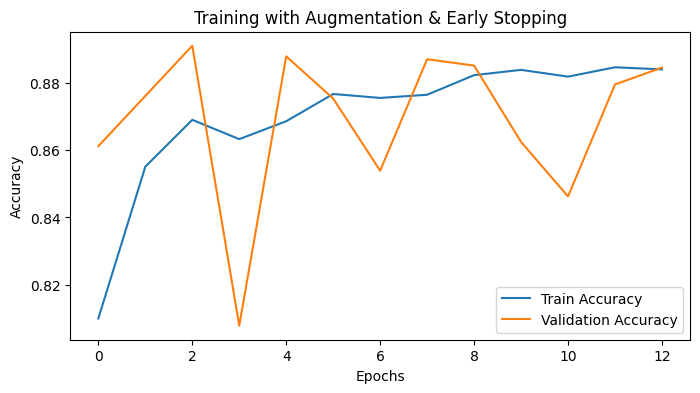

In [50]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training with Augmentation & Early Stopping")
plt.legend()
plt.show()

In [10]:
import os
import numpy as np
import librosa
import librosa.effects
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars (pip install tqdm if needed)

# Check GPU availability (useful on Apple Silicon or other GPU-enabled environments)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU Enabled")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

# (Optional) Mixed Precision
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed Precision set to FP16")
except:
    print("mixed_float16 not supported, falling back to float32.")
    policy = mixed_precision.Policy('float32')
    mixed_precision.set_global_policy(policy)

No GPU found, using CPU.
Mixed Precision set to FP16


In [3]:
# Suppose the dataset root folder is:
# UA_Speech/
#    HIGH/
#    LOW/
#    MEDIUM/
#    VERY LOW/

dataset_root = "Documents/Kashvi/UA_Speech"  # Update with the actual path if needed

# We'll define severity folder mapping
severity_folders = {
    "VERY LOW": 0,
    "LOW": 1,
    "MEDIUM": 2,
    "HIGH": 3
}

In [4]:
# Audio & Feature Extraction
SAMPLE_RATE = 44100
N_MFCC = 13

# Adjust these if needed
TIME_STRETCH_PROB = 0.3
PITCH_SHIFT_PROB = 0.3
NOISE_PROB = 0.3

In [5]:
def extract_features(file_path):
    """
    Extracts MFCC and Mel Spectrogram features from an audio file.
    Includes optional (mild) data augmentation.
    """
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # (a) Random Time Stretching
    if np.random.rand() < TIME_STRETCH_PROB:
        rate = np.random.uniform(0.9, 1.1)
        y = librosa.effects.time_stretch(y, rate=rate)
    
    # (b) Random Pitch Shift
    if np.random.rand() < PITCH_SHIFT_PROB:
        semitones = np.random.uniform(-1, 1)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=semitones)
    
    # (c) Random Noise Injection
    if np.random.rand() < NOISE_PROB:
        noise = np.random.normal(0, 0.003, y.shape)
        y = y + noise

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    # Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    mfcc_mean = np.mean(mfccs, axis=1)
    mel_mean = np.mean(mel_db, axis=1)
    
    features = np.hstack((mfcc_mean, mel_mean)).astype(np.float32)
    return features

In [6]:
def collect_data_from_folders(root_path, folder_mapping):
    """
    Scans each folder in `folder_mapping` and loads .wav files.
    Returns features (X) and labels (y).
    folder_mapping is a dict like {"VERY LOW": 0, "LOW": 1, "MEDIUM": 2, "HIGH": 3}.
    """
    X_list = []
    y_list = []
    
    for folder_name, label_value in folder_mapping.items():
        folder_path = os.path.join(root_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist. Skipping.")
            continue
        
        # Gather all wav files
        wav_files = [
            f for f in os.listdir(folder_path) 
            if f.endswith(".wav")
        ]
        print(f"Found {len(wav_files)} wav files in {folder_name} folder.")
        
        for wav_file in tqdm(wav_files, desc=f"Processing {folder_name}"):
            file_path = os.path.join(folder_path, wav_file)
            feats = extract_features(file_path)
            X_list.append(feats)
            y_list.append(label_value)
    
    return np.array(X_list), np.array(y_list)

In [7]:
# Collect data
X, y = collect_data_from_folders(dataset_root, severity_folders)

if len(X) == 0:
    raise ValueError("No data found. Check your dataset path and folder structure.")

print(f"\nTotal samples: {len(X)}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize by training set max
train_max = np.max(X_train)
X_train = X_train / train_max
X_test = X_test / train_max

# Build tf.data pipeline
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Found 3825 wav files in VERY LOW folder.


Processing VERY LOW: 100%|██████████████████| 3825/3825 [02:08<00:00, 29.84it/s]


Found 2281 wav files in LOW folder.


Processing LOW: 100%|███████████████████████| 2281/2281 [01:37<00:00, 23.37it/s]


Found 2295 wav files in MEDIUM folder.


Processing MEDIUM: 100%|████████████████████| 2295/2295 [01:46<00:00, 21.57it/s]


Found 3036 wav files in HIGH folder.


Processing HIGH: 100%|██████████████████████| 3036/3036 [02:54<00:00, 17.40it/s]



Total samples: 11437


In [11]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output for 4 classes
    Dense(4, activation='softmax', dtype=tf.float32)
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               36352     
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


2025-04-16 00:08:34.866436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [9149]
	 [[{{node Placeholder/_1}}]]


 35/286 [==>...........................] - ETA: 0s - loss: 1.7695 - accuracy: 0.3152  

2025-04-16 00:08:35.256184: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


286/286 [==============================] - 1s 2ms/step - loss: 1.4698 - accuracy: 0.4141 - val_loss: 1.4176 - val_accuracy: 0.2198
Epoch 2/50
 33/286 [==>...........................] - ETA: 0s - loss: 1.2859 - accuracy: 0.4716

2025-04-16 00:08:35.819320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2288]
	 [[{{node Placeholder/_1}}]]


286/286 [==============================] - 0s 2ms/step - loss: 1.2109 - accuracy: 0.5135 - val_loss: 1.0247 - val_accuracy: 0.5848
Epoch 3/50
286/286 [==============================] - 0s 2ms/step - loss: 1.0950 - accuracy: 0.5569 - val_loss: 0.9760 - val_accuracy: 0.5892
Epoch 4/50
286/286 [==============================] - 0s 2ms/step - loss: 1.0201 - accuracy: 0.5980 - val_loss: 0.8589 - val_accuracy: 0.6630
Epoch 5/50
286/286 [==============================] - 0s 1ms/step - loss: 0.9504 - accuracy: 0.6232 - val_loss: 0.8713 - val_accuracy: 0.6503
Epoch 6/50
286/286 [==============================] - 0s 2ms/step - loss: 0.9112 - accuracy: 0.6391 - val_loss: 0.9543 - val_accuracy: 0.6224
Epoch 7/50
286/286 [==============================] - 0s 2ms/step - loss: 0.8794 - accuracy: 0.6533 - val_loss: 0.8651 - val_accuracy: 0.6298
Epoch 8/50
286/286 [==============================] - 0s 2ms/step - loss: 0.8396 - accuracy: 0.6694 - val_loss: 0.7739 - val_accuracy: 0.6993
Epoch 9/50
286/28

In [13]:
model.save("speech_severity_classifier.h5")

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

72/72 [==============================] - 0s 966us/step - loss: 0.5741 - accuracy: 0.7928
Test Accuracy: 79.28%


In [14]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

72/72 [==============================] - 0s 517us/step

Classification Report:
              precision    recall  f1-score   support

           0     0.8285    0.8144    0.8214       765
           1     0.7022    0.8224    0.7576       456
           2     0.8228    0.7081    0.7611       459
           3     0.8089    0.8076    0.8082       608

    accuracy                         0.7928      2288
   macro avg     0.7906    0.7881    0.7871      2288
weighted avg     0.7970    0.7928    0.7931      2288

Confusion Matrix:
 [[623  65  25  52]
 [ 41 375  13  27]
 [ 33  64 325  37]
 [ 55  30  32 491]]


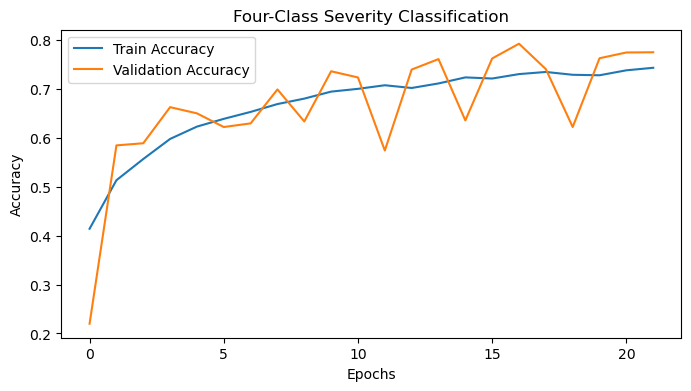

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Four-Class Severity Classification")
plt.legend()
plt.show()